In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import edward2 as ed
import warnings

/home/simon/miniconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/simon/miniconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/simon/miniconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/simon/miniconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/simon/miniconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: 

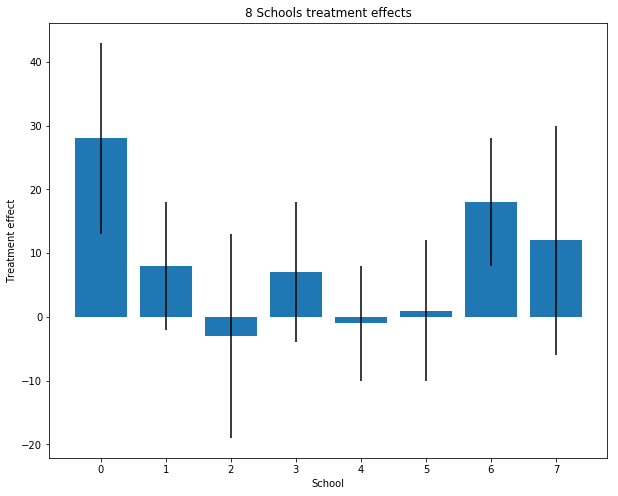

In [3]:
num_schools = 8  # number of schools
treatment_effects = np.array(
    [28, 8, -3, 7, -1, 1, 18, 12], dtype=np.float32)  # treatment effects
treatment_stddevs = np.array(
    [15, 10, 16, 11, 9, 11, 10, 18], dtype=np.float32)  # treatment SE

fig, ax = plt.subplots()
plt.bar(range(num_schools), treatment_effects, yerr=treatment_stddevs)
plt.title("8 Schools treatment effects")
plt.xlabel("School")
plt.ylabel("Treatment effect")
fig.set_size_inches(10, 8)
plt.show()

In [4]:
def schools_model(num_schools, treatment_stddevs):
  avg_effect = ed.Normal(loc=0., scale=10., name="avg_effect")  # `mu` above
  avg_stddev = ed.Normal(
      loc=5., scale=1., name="avg_stddev")  # `log(tau)` above
  school_effects_standard = ed.Normal(
      loc=tf.zeros(num_schools),
      scale=tf.ones(num_schools),
      name="school_effects_standard")  # `theta_prime` above
  school_effects = avg_effect + tf.exp(
      avg_stddev) * school_effects_standard  # `theta` above
  treatment_effects = ed.Normal(
      loc=school_effects, scale=treatment_stddevs,
      name="treatment_effects")  # `y` above
  return treatment_effects

log_joint = ed.make_log_joint_fn(schools_model)


def target_log_prob_fn(avg_effect, avg_stddev, school_effects_standard):
  """Unnormalized target density as a function of states."""
  return log_joint(
      num_schools=num_schools,
      treatment_stddevs=treatment_stddevs,
      avg_effect=avg_effect,
      avg_stddev=avg_stddev,
      school_effects_standard=school_effects_standard,
      treatment_effects=treatment_effects)

In [6]:
num_results = 5000
num_burnin_steps = 3000

states, kernel_results = tfp.mcmc.sample_chain(
    num_results = num_results,
    num_burnin_steps = num_burnin_steps,
    current_state = [
        tf.zeros([], name='init_avg_effect'),
        tf.zeros([], name='init_avg_stddev'),
        tf.ones([num_schools], name='init_school_effects_standard'),
    ],
    kernel = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn = target_log_prob_fn,
        step_size = 0.4,
        num_leapfrog_steps = 3))

avg_effect, avg_stddev, school_effects_standard = states

/home/simon/miniconda3/envs/tensorflow/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


In [7]:
with tf.Session() as sess:
    [avg_effect_, avg_stddev_,
     school_effects_standard_,
     is_accepted_] = sess.run([avg_effect, avg_stddev,
      school_effects_standard, kernel_results.is_accepted])

In [8]:
school_effects_samples = (
    avg_effect_[:, np.newaxis] +
    np.exp(avg_stddev_)[:, np.newaxis] * school_effects_standard_)
num_accepted = np.sum(is_accepted_)
print('Acceptance rate: {}'.format(num_accepted / num_results))

Acceptance rate: 0.6154


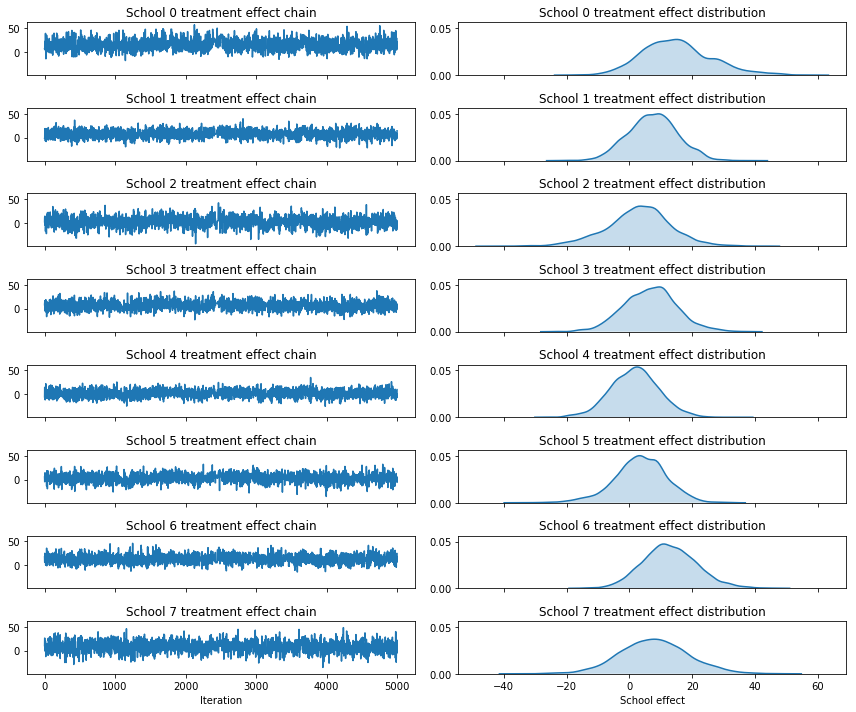

In [9]:
fig, axes = plt.subplots(8, 2, sharex='col', sharey='col')
fig.set_size_inches(12, 10)
for i in range(num_schools):
  axes[i][0].plot(school_effects_samples[:,i])
  axes[i][0].title.set_text("School {} treatment effect chain".format(i))
  sns.kdeplot(school_effects_samples[:,i], ax=axes[i][1], shade=True)
  axes[i][1].title.set_text("School {} treatment effect distribution".format(i))
axes[num_schools - 1][0].set_xlabel("Iteration")
axes[num_schools - 1][1].set_xlabel("School effect")
fig.tight_layout()
plt.show()